In [1]:
from PIL import Image
import skimage.io

import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import math 
import os
import shutil
import numpy as np
from datetime import datetime
import Augmentor
import cv2

In [2]:
purple = np.array([255, 27, 255, 255])
yellow = np.array([255, 255, 27, 255])
blue = np.array([27, 27, 255, 255])
red = np.array([255, 27, 27, 255])
lightblue = np.array([27, 255, 255, 255])
green = np.array([27, 255, 27, 255])
orange = np.array([255, 155, 27, 255])
white = np.array([255, 255, 255, 255])
black = np.array([0, 0, 0, 255])

rmFuncMap = {
    'bedroom': purple,
    'livingroom': yellow,
    'bathroom': blue,
    'kitchen': red,
    'storageroom': lightblue,
    'deckNporch': green,
    'corridor': orange,
    'background': white,
}

blWhMap = {
    'black': black,
    'white': white,
}

augmentedPath = Path('/home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Augmented_floorplan/')
augmentedPath.mkdir(parents=True, exist_ok=True)
sourcePath = Path('/home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Source Images')
oriPath = Path('/home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Original')
pathA = augmentedPath / 'A'
pathA.mkdir(parents=True, exist_ok=True)
pathB = augmentedPath / 'B'
pathB.mkdir(parents=True, exist_ok=True)
newCombinedPath = augmentedPath / f"Combined_{datetime.now().strftime('%Y_%m_%d_%H_%M')}"
newCombinedPath.mkdir(parents=True, exist_ok=True)
# pathB_processed = augmentedPath / f"B_processed"
# pathB_processed.mkdir(parents=True, exist_ok=True)

test_dir = newCombinedPath / 'Test'
train_dir = newCombinedPath / 'Train'
test_dir.mkdir(parents=True, exist_ok=True)
train_dir.mkdir(parents=True, exist_ok=True)

In [3]:
def replaceCloestColor(img, rmFuncMap): 
    thresh = 30
    
    # Select room colors that are common in the image  
    vals, counts = np.unique(img.reshape(-1, 4), axis=0, return_counts=True)
    
    imgRmColor = set(map(tuple, vals[counts>thresh])) # form a set of values/counts > threshold
    rmColorMap = set(map(tuple, rmFuncMap.values())) # form a set of room func color map

    rmColor = np.array(list(imgRmColor.intersection(rmColorMap))) # Select the resonable colors in the room func map only
    
    # Determine color differences (Use additional dimension)
    # Compute the shortest Euclidean distance within the color map 
    color_diffs = np.sum((img[:,:,None,:]-rmColor)[...,:-1]**2,axis=-1)**0.5
    
    # Get the indices of the closest value
    idx = np.argmin(color_diffs,axis=-1)

    # Extract closest value to assemble array 
    img = rmColor[idx]
    
    return img 

def generateBlWhImg(img): 
    iswhite = (img == white).all(axis=2)
    img[~iswhite] = black
    return img

def unblur(img):
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(img, -1, sharpen_kernel)
    return sharpen

In [21]:
p = Augmentor.Pipeline(oriPath / 'B')
p.ground_truth(sourcePath)

# Add operations to the pipeline:
p.rotate90(probability=0.25)
p.rotate270(probability=0.25)
p.flip_left_right(probability=0.25)
p.flip_top_bottom(probability=0.25)

IMAGE_COUNT = 300
p.sample(IMAGE_COUNT)

for file in (oriPath / 'B' / 'output').glob("*.png"):
    if 'original' in file.name:
        dst = pathA / file.name[-16:]
    elif '_groundtruth_' in file.name:
        dst = pathB / file.name[-16:]
        
    shutil.copyfile(file, dst)
shutil.rmtree(oriPath / 'B' / 'output')

Initialised with 104 image(s) found.
Output directory set to /home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Original/B/output.

104 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGBA size=256x256 at 0x7F6330A83B70>: 100%|██████████| 300/300 [00:01<00:00, 231.47 Samples/s]                


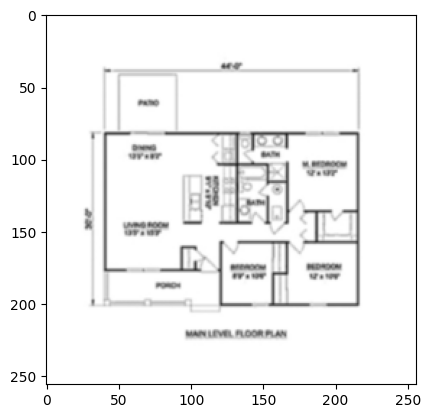

In [9]:
myfile = Path('/home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Source Images/0.png')
img = skimage.io.imread(myfile)
plt.imshow(img)

(253, 4)


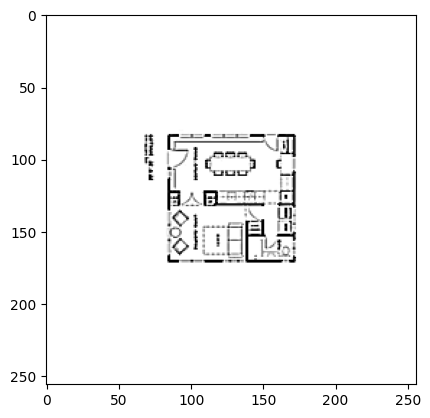

In [17]:
myfile = Path('/home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Augmented_floorplan/B/00aaeaeb853b.png')
img = skimage.io.imread(myfile)

# img = generateBlWhImg(img.copy())
img = unblur(img.copy())
plt.imshow(img)
unique_pix_val = np.unique(img.reshape(-1, 4), axis=0)
print(unique_pix_val.shape)

In [23]:
newCombinedPath.mkdir(parents=True, exist_ok=True)

# Combine Augmented Images into the pair format that Pix2Pix expects
for file in pathA.glob("*.png"):
  
  im1 = skimage.io.imread(file)
  # im2 = skimage.io.imread(oriPath / 'A' / file.name)
  im2 = skimage.io.imread(pathB / file.name)
  dst = np.hstack((replaceCloestColor(im1, rmFuncMap), unblur(im2)))
  skimage.io.imsave(newCombinedPath / file.name, dst)

/home/user1/anaconda3/envs/pix2pix/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: /home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Augmented_floorplan/Combined_2023_03_09_15_17/dd6498cc7938.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/home/user1/anaconda3/envs/pix2pix/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: /home/user1/Documents/Ricky/pix2pix-floorplans-dataset/dataset/Augmented_floorplan/Combined_2023_03_09_15_17/4cffc60851c2.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/home/user1/anaconda3/envs/pix2pix/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: /home/user1/Documents/Ricky/pix2pix-floorplans-d

In [26]:
ratio = 0.15

test_dir.mkdir(parents=True, exist_ok=True)
train_dir.mkdir(parents=True, exist_ok=True)

for file in newCombinedPath.glob("*.png"):
      if np.random.rand(1) < ratio:
          shutil.copyfile(file, test_dir / file.name)
      else:
          shutil.copyfile(file, train_dir / file.name)